<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [8]</a>'.</span>

# The Cookbook of Neural ODEs

Torchdyn implements out-of-the-box a variety of continuous-depth models. In this introductory tutorial, we show how we can switch between model variants with minor effort. We will touch upon the following Neural ODE variants:

* **Vanilla** (depth-invariant) (same as the [torchdyn quickstart](./00_quickstart.html) tutorial)
* **Vanilla** (depth-variant)
* **Galerkin**
* **Data-controlled**
* **Stacked (piece-wise constant weights)**
* **Stacked with discrete state transitions**
--------------------------------------

For more advanced models check out 

* [Hamiltonian Neural Networks](./06a_hamiltonian_nn.html)
* [Lagrangian Neural Networks](./06b_lagrangian_nn.html)
* [Continuous Normalizing Flow](./07_continuous_normalizing_flow.html)
* [Graph Neural ODEs](./08_graph_neural_de.html)

In [1]:
from torchdyn.core import NeuralODE
from torchdyn.nn import DataControl, DepthCat, Augmenter, GalLinear, Fourier
from torchdyn.datasets import *
from torchdyn.utils import *

**Data:** we use again the moons dataset (with some added noise) simply because all the models will be effective to solve this easy binary classification problem.



In [2]:
d = ToyDataset()
X, yn = d.generate(n_samples=512, dataset_type='moons', noise=.1)

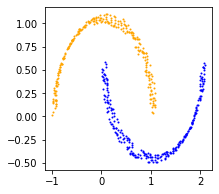

In [3]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], s=1, color=colors[yn[i].int()])

In [4]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

**Learner**

In [5]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)   
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.005)

    def train_dataloader(self):
        return trainloader

**Note:** In this notebook we will consider the depth domain $[0,1]$, i.e. $s\in[0,1]$. Note that, for most architectures in *static* settings (aka we do not deal with dynamic data) any other depth domain does not actually affect the expressiveness of Neural ODEs, since it can be seen as a rescaled/shifted version of $[0,1]$. Please note that, however, other choices of the depth domain can indeed affect the training phase

The depth domain can be accessed and modified through the `s_span` setting of `NeuralDE` instances.

## Vanilla Neural ODE (Depth-Invariant)

$$ \left\{
    \begin{aligned}
        \dot{z}(s) &= f(z(s), \theta)\\
        z(0) &= x\\
        \hat y & = z(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

This model is the same used in [torchdyn quickstart](./00_quickstart.html) tutorial. The vector field is parametrized by a neural network $f$ with *static* parameters $\theta$ and taking as input only the state $h(s)$.

In [6]:
# vector field parametrized by a NN
f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Tanh(), 
        nn.Linear(64, 2))

# Neural ODE
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)

In [7]:
# train the Neural ODE
learn = Learner(model)
trainer = pl.Trainer(min_epochs=200, max_epochs=250, progress_bar_refresh_rate=1)
trainer.fit(learn)

GPU available: True, used: False


TPU available: False, using: 0 TPU cores


/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  warnings.warn(*args, **kwargs)

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 322   
------------------------------------
322       Trainable params
0         Non-trainable params
322       Total params
0.001     Total estimated model params size (MB)


/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

**Plots**

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [8]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X))

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))

## Vanilla Neural ODE (Depth-Variant)

$$ \left\{
    \begin{aligned}
        \dot{z}(s) &= f(s, z(s), \theta)\\
        z(0) &= x\\
        \hat y & = z(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

This model, contemplated by the seminal paper from [[Chen T. Q. et al, 2018]](https://arxiv.org/abs/1806.07366), is usually obtained by concatenating $s$ to the state $h$ as input of $f$, i.e. $f([h(s),s])$. For a simple and flexible implementation we developed a dedicated layer, `DepthCat`, which takes care of automatically concatenating $s$ to the state at each call of the `DEFunc`. The final user only needs to specify concatenation dimension to which $s$ should be appended. Specifically, for an MLP, $h\in\mathbb{R}^{batch\times dims}$ and, thus we should use `DepthCat(1)`.

In [ ]:
# vector field parametrized by a NN
f = nn.Sequential(
        DepthCat(1),
        nn.Linear(2+1, 64),
        nn.Tanh(),
        DepthCat(1),
        nn.Linear(64+1, 2))

# Neural ODE
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)

In [ ]:
# train the Neural ODE
learn = Learner(model)
trainer = pl.Trainer(min_epochs=200, max_epochs=250, progress_bar_refresh_rate=1)
trainer.fit(learn)

**Plot**

In [ ]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X))

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))

## Galerkin-Style Neural ODE

Galerkin-style Neural ODEs proposed in [Massaroli S., Poli M. et al., 2020](https://arxiv.org/abs/2002.08071) make the weights of the neural ODE to be *depth-varying*, i.e. $\theta=\theta(s)$ obtaining a model of type

$$
    \left\{
    \begin{aligned}
        \dot{z}(s) &= f(z(s), \theta(s))\\
        z(0) &= x\\
        \hat y & = z(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

where the depth evolution of $\theta(s)$ is parametrized by a trucated eigenfunction expasion, usually an orthogonal basis of some functional space, i.e.

$$
    \forall i \quad \theta_i(s) = \sum_{j=0}^{m}\gamma_j\odot\psi_j(s)
$$

The model is then trained by optimizing for the eigenvalues $\gamma_j$. Note that if $\theta\in \mathbb{R}^d$ there will be $d\times m$ final model's parameters. In this tutorial, we use a 10th-order polynomial expansion to model $\theta(s)$.

**Note:** In `torchdyn 0.1.0` only Fourier `FourierExpansion` and polynomial `PolyExpansion` bases are currently implemented out-of-the-box. Even though a wider selection of bases is planned as a future addition, e.g.  piece-wise constant functions, radial basis functions, etc., users can easily create custom `Expansions` on their own given `torchdyn`'s modular design.

In [ ]:
# vector field parametrized by a NN with "GalLinear" layer
# notice how DepthCat is still used since Galerkin layers make use of `s` (though in a different way compared to concatenation)
f = nn.Sequential(DepthCat(1), 
                  GalLinear(2, 32, expfunc=Fourier(5)),
                  nn.Tanh(),
                  nn.Linear(32, 2))
# neural ODE
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)

In [ ]:
# train the Neural ODE
learn = Learner(model)
trainer = pl.Trainer(min_epochs=150, max_epochs=200, progress_bar_refresh_rate=1)
trainer.fit(learn)

**Plot**

In [ ]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X))

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))

## Data-Controlled Neural ODE

Data-controlled neural ODEs, also introduced in [Massaroli S., Poli M. et al., 2020](https://arxiv.org/abs/2002.08071) consist in feeding to the vector field the input data $x$ (the initial condition of the ODE), leading to

$$ \left\{
    \begin{aligned}
        \dot{z}(s) &= f(z(s), x, \theta)\\
        z(0) &= x\\
        \hat y & = z(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

In this way, the Neural ODE learns a family of vector fields rather than a single one. 

In practice, we concatenate $x$ to $h$ and simply feed $[h, x]$ to $f$, which should indeed be defined to accomodate the extra $dim(x)$ dimensions. Data-control inputs can be defined at any point in `f` via use of `DataControl`.

In [ ]:
# vector field parametrized by a NN which takes as input [h, x]
f = nn.Sequential(DataControl(),
                  nn.Linear(2+2, 64),
                  nn.Tanh(),
                  nn.Linear(64, 2))

# neural ODE
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)

In [ ]:
learn = Learner(model)
trainer = pl.Trainer(min_epochs=150, max_epochs=250)
trainer.fit(learn)

**Plots**

In [ ]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X))

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))

## Stacked Neural ODE (aka Piece-wise constant parameters)

While looking for an "easier" solution than Galererkin Neural ODEs without trading the expressivity of the model, **stacked neural ODEs** may come in handy. Instead of approximating the solution of an infinite-dimensional problem (e.g. Galerkin-style), we can also use piece-wise constant weight functions. Let us subdivide the depth in $N$ intervals
    
$$
        \mathcal{S} = \prod_{i=0}^{N}[s_i,s_{i+1}], \quad s_0 = 0, \quad s_{N+1}=S  \quad(\forall i  \quad s_i\leq s_{i+1})
$$

We can then define the weights as piece-wise constant functions 

$$
        \forall i  \quad s\in[s_i,s_{i+1}]\Rightarrow\theta(s) = \theta_i, \quad\theta_i\in\{\theta_1,\theta_2,\theta_N\}
$$
    
The solution of the neural ODE becomes 
    
$$
    \begin{aligned}
        z(s) &= x + \int_0^S f(z(\tau),\theta(\tau))d\tau \\
        &= x + \sum_{i=1}^{N-1}\int_{s_i}^{s_{i+1}} f(z(\tau),\theta_i)d\tau
    \end{aligned}
$$
    
This is equivalent to stacking $N-1$ neural ODEs with **identical structure** and **disentangled weights**
    
$$
        \begin{aligned}
         \dot z =  f( z(s),\theta_i) \quad s\in[s_i,s_{i+1}]
        \end{aligned}
$$
    
which are **stacked sequentially** and trained with *classic* adjoint method.

In principle, $f$ can be chosen arbitrarily. Hereafter we consider, e.g. the `data-controlled` case.

**NOTE:** Let $\Delta s_i = s_{i+1} - s_i$. Since the individual Neural ODEs are *depth-invariant*, we can just solve the ODEs in $[0,\Delta s_i]$

In [ ]:
# We choose to divide the domain [0,1] in num_pieces=5 intervals
num_pieces = 5

# Stacked depth-invariant Neural ODEs aka Neural ODEs with piecewise constant weights 
nde = []
for i in range(num_pieces):
    nde.append(NeuralODE(nn.Sequential(DataControl(),
                                      nn.Linear(4, 4), 
                                      nn.Tanh(), 
                                      nn.Linear(4, 2)), solver='dopri5', s_span=torch.linspace(0, 1, 2))) # here we chose Δ𝑠_𝑖 = 1 ∀𝑖. (s_span)
model = nn.Sequential(*nde).to(device)

In [ ]:
learn = Learner(model)
trainer = pl.Trainer(min_epochs=300, max_epochs=350)
trainer.fit(learn)

**Plots**

In [ ]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,20)
trajectory = [model[0].trajectory(X_train, s_span)]
for i in range(1, num_pieces):
    trajectory.append(
        model[i].trajectory(trajectory[i-1][-1,:,:], s_span))
                      
trajectory = torch.cat(trajectory, 0).detach().cpu() 
tot_s_span = torch.linspace(0, 5, 100)

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(tot_s_span, trajectory, yn, len(X))

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X))

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(tot_s_span, trajectory, yn, len(X))

## Stacked Neural ODEs with Discrete State Transitions

These are basically the `Stacked` model where, at the end of an interval $[s_i, s_{i+1}]$, the state is also updated by learned transition maps $g(h, \omega_i)$ parametrized by a NN, i.e.

$$
  \left\{
        \begin{aligned}
             \dot z &=  f(z(s),\theta_i) \quad s\in[s_i,s_{i+1}]\\
             z^+ &= g(z(s),\omega_i) \quad s = s_{i+1}
        \end{aligned}
  \right.
$$

**NOTE:** While not standard, this class highlights how Neural ODE variants can be put together hassle-free via torchdyn's API.


In [ ]:
# We choose to divide the domain [0,1] in num_pieces=5 intervals
num_pieces = 5

# stacked depth-invariant Neural ODEs
nde = []
for i in range(num_pieces):
    nde.append(NeuralODE(nn.Sequential(DataControl(),
                                      nn.Linear(4, 4), 
                                      nn.Tanh(), 
                                      nn.Linear(4, 2)), solver='dopri5'))
    # In this case the state "jump" is parametrized by a simple linear layer
    nde.append(
        nn.Linear(2, 2)
    )
    
model = nn.Sequential(*nde).to(device)

In [ ]:
learn = Learner(model)
trainer = pl.Trainer(min_epochs=200, max_epochs=250)
trainer.fit(learn)

**Plots**

In [ ]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,20)
trajectory = [model[0].trajectory(X_train, s_span)]
i = 2
c = 0
while c < num_pieces-1:
    x0 = model[i-1](trajectory[c][-1,:,:])
    trajectory.append(
        model[i].trajectory(x0, s_span))
    i += 2
    c += 1
                      
trajectory = torch.cat(trajectory, 0).detach().cpu() 
tot_s_span = torch.linspace(0, 5, 100)

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(tot_s_span, trajectory, yn, len(X))

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X))

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(tot_s_span, trajectory, yn, len(X))